In [3]:
import xgboost as xgb
import numpy as np
def log_reg(y_hat,y):
    p = 1 / (1+np.exp(-y_hat))
    g = p - y.get_label()
    h = p * (1-p)
    return g,h
def error_rate(y_hat,y):
    return 'error',float(sum(y.get_label()!=(y_hat > 0.5)))/len(y_hat)

data_train = xgb.DMatrix('12.agaricus_train.txt')
data_test = xgb.DMatrix('12.agaricus_test.txt')
param = {'max_depth':2,'eta':1,'silent':1,'objective':'binary:logistic'}
watchlist = [(data_test,'eval'),(data_train,'train')]
n_round = 4
bst = xgb.train(param,data_train,num_boost_round=n_round,evals=watchlist,obj=log_reg)

y_hat = bst.predict(data_test)
y = data_test.get_label()
print(y_hat)
print(y)
error = sum(y!=(y_hat>0.5))
error_rate = float(error)/len(y_hat)
print('样本总数：',len(y_hat))
print('错误数目：',error)
print('错误率：',error_rate)

[10:03:32] 6513x126 matrix with 143286 entries loaded from 12.agaricus_train.txt
[10:03:32] 1611x126 matrix with 35442 entries loaded from 12.agaricus_test.txt
[0]	eval-error:0.042831	train-error:0.046522
[1]	eval-error:0.042831	train-error:0.046522
[2]	eval-error:0.075109	train-error:0.072317
[3]	eval-error:0.042831	train-error:0.046522
[2.8126610e-03 6.5118724e-01 2.8126610e-03 ... 9.9479783e-01 2.0532969e-04
 9.9479783e-01]
[0. 1. 0. ... 1. 0. 1.]
样本总数： 1611
错误数目： 69
错误率： 0.04283054003724395


[0]	eval-merror:0.24	train-merror:0.20202
[1]	eval-merror:0.2	train-merror:0.191919
[2]	eval-merror:0.26	train-merror:0.161616
[3]	eval-merror:0.3	train-merror:0.141414
[4]	eval-merror:0.26	train-merror:0.131313
[5]	eval-merror:0.26	train-merror:0.131313
正确率： 0.74


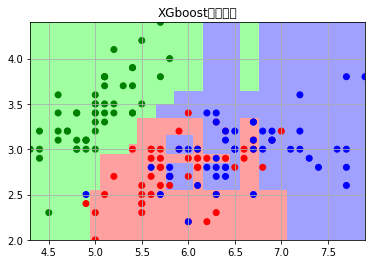

In [5]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '8.iris.data'
df = pd.read_csv(path)
x = df.values[:,:2]
y = df.values[:,-1]
le = preprocessing.LabelEncoder()
le.fit(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
y = le.transform(y)
y = np.array(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1,test_size=50)

data_train = xgb.DMatrix(x_train,label=y_train)
data_test = xgb.DMatrix(x_test,label=y_test)
watch_list = [(data_test,'eval'),(data_train,'train')]
param = {'max_depth':3,'eta':1,'silent':1,'objective':'multi:softmax','num_class':3}

bst = xgb.train(param,data_train,num_boost_round=6,evals=watch_list)
y_hat = bst.predict(data_test)
result = y_test.reshape(1,-1)==y_hat
print('正确率：',float(np.sum(result))/len(y_hat))

x1_min,x1_max = x[:,0].min(),x[:,0].max()
x2_min,x2_max = x[:,1].min(),x[:,1].max()
x1 = np.linspace(x1_min,x1_max,200)
x2 = np.linspace(x2_min,x2_max,200)
t1,t2 = np.meshgrid(x1,x2)
x_show = np.stack((t1.flat,t2.flat),axis=1)
y_show = np.ones((200,1))
data_pre = xgb.DMatrix(x_show,label=y_show)
y_pre = bst.predict(data_pre).reshape(t1.shape)

cm_light = mpl.colors.ListedColormap(['#A0FFA0','#FFA0A0','#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g','r','b'])
plt.pcolormesh(x1,x2,y_pre,cmap=cm_light)
plt.scatter(x[:,0],x[:,1],c=y,cmap=cm_dark)
plt.title('XGboost分类结果')
plt.xlim(x1_min,x1_max)
plt.ylim(x2_min,x2_max)
plt.grid()
plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression

path = '12.wine.data'
df = pd.read_csv(path)
x = df.values[:,1:]
y = df.values[:,0]
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=1,test_size=0.5)

lr = LogisticRegression()
lr.fit(x_train,y_train)
y_hat1 = lr.predict(x_test)
result1 = y_hat1 == y_test
print('Logistic正确率：',float(sum(result1))/len(y_hat1))

y_train[y_train == 3] = 0
y_test[y_test == 3] = 0
data_train = xgb.DMatrix(x_train,label=y_train)
data_test = xgb.DMatrix(x_test,label=y_test)
watch_list = [(data_test,'test'),(data_train,'train')]
param = {'max_depth':4,'eta':1,'silent':1,'objective':'multi:softmax','num_class':3}
bst = xgb.train(param,data_train,num_boost_round=3,evals=watch_list)
y_hat2 = bst.predict(data_test)
result2 = y_hat2 == y_test
print('XGboost正确率：',float(sum(result2))/len(y_hat2))

Logistic正确率： 0.9550561797752809
[0]	test-merror:0.123596	train-merror:0.011364
[1]	test-merror:0.05618	train-merror:0
[2]	test-merror:0.033708	train-merror:0
XGboost正确率： 0.9662921348314607


In [29]:
import scipy.sparse

def read_data(path):
    y = []
    row = []
    col = []
    values = []
    r = 0
    for d in open(path):
        d = d.strip().split()
        y.append(int(d[0]))
        d = d[1:]
        for c in d:
            key,value = c.split(':')
            row.append(r)
            col.append(int(key))
            values.append(float(value))
        r+=1
    x = scipy.sparse.csr_matrix((values,(row,col))).toarray()
    y = np.array(y)
    return x,y

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import csv


def load_data(file_name,is_train):
    data = pd.read_csv(file_name)
    data['Sex'] = data['Sex'].map({'female':0,'male':1}).astype(int)
    
    if len(data.Fare[data.Fare.isnull()]) > 0:
        fare = np.zeros(3)
        for f in range(3):
            fare[f] = data[data.Pclass==f+1]['Fare'].dropna().median()
        for f in range(3):
            data.loc[(data.Fare.isnull()) & (data.Pclass==f+1),'Fare'] = fare[f]
            
    if is_train:
        data_for_age = data[['Age', 'Survived', 'Fare', 'Parch', 'SibSp', 'Pclass']]
        age_exist = data_for_age.loc[(data.Age.notnull())]
        age_null = data_for_age.loc[(data.Age.isnull())]
        x = age_exist.values[:,1:]
        y = age_exist.values[:,0]
        rfr = RandomForestRegressor(n_estimators=1000)
        rfr.fit(x,y)
        age_hat = rfr.predict(age_null.values[:,1:])
        data.loc[(data.Age.isnull()),'Age'] = age_hat
        
    else:
        data_for_age = data[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
        age_exist = data_for_age.loc[(data.Age.notnull())]
        age_null = data_for_age.loc[(data.Age.isnull())]
        x = age_exist.values[:,1:]
        y = age_exist.values[:,0]
        rfr = RandomForestRegressor(n_estimators=1000)
        rfr.fit(x,y)
        age_hat = rfr.predict(age_null.values[:,1:])
        data.loc[(data.Age.isnull()),'Age'] = age_hat
        
    data.loc[(data.Embarked.isnull()),'Embarked'] = 'S'
    embarked_data = pd.get_dummies(data.Embarked)
    embarked_data = embarked_data.rename(columns=lambda x:'Embarked_'+str(x))
    data = pd.concat([data,embarked_data],axis=1)
    data.to_csv('New_Data.csv')
    
    x = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
    y = None
    if 'Survived' in data:
        y = data['Survived']
        
    x = np.array(x)
    y = np.array(y)
    if is_train:
        return x,y
    return x,np.array(data['PassengerId']).astype(int)

def write_result(c,c_type):
    file_name = '12.Titanic.test.csv'
    x,passenger_id = load_data(file_name,False)
    
    if c_type == 3:
        x = xgb.DMatrix(x)
    y = c.predict(x)
    y[y>0.5] = 1
    y[~(y>0.5)] = 0
    
    predictions_file = open('Prediction_%d.csv'%c_type,'w')
    cw = csv.writer(predictions_file)
    
    cw.writerows(zip(passenger_id,y))
    predictions_file.close()
    
    
x,y = load_data('12.Titanic.train.csv', True)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.5,random_state=1)

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)
result = y_hat==y_test
print('Logistics正确率：',float(sum(result))/len(y_test))
write_result(lr,1)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)
y_hat = rfc.predict(x_test)
result = y_hat==y_test
print('随机森林正确率：',float(sum(result))/len(y_test))
write_result(rfc,2)

data_train = xgb.DMatrix(x_train,label=y_train)
data_test = xgb.DMatrix(x_test,label=y_test)
watch_list = [(data_test,'test'),(data_train,'train')]
param = {'max_depth':4,'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'}
bst = xgb.train(param, data_train, num_boost_round=6, evals=watch_list)
y_hat = bst.predict(data_test)
y_hat[y_hat > 0.5] = 1
y_hat[~(y_hat > 0.5)] = 0
result = y_hat==y_test
print('XGboost正确率：',float(sum(result))/len(y_test))
write_result(bst,3)





Logistics正确率： 0.7780269058295964
随机森林正确率： 0.8094170403587444
[0]	test-error:0.199552	train-error:0.12809
[1]	test-error:0.199552	train-error:0.12809
[2]	test-error:0.199552	train-error:0.12809
[3]	test-error:0.197309	train-error:0.132584
[4]	test-error:0.197309	train-error:0.132584
[5]	test-error:0.197309	train-error:0.132584
XGboost正确率： 0.8026905829596412


0.8874562518771993
0.6552341440228306
-2.530387494412951
0.94699729553349


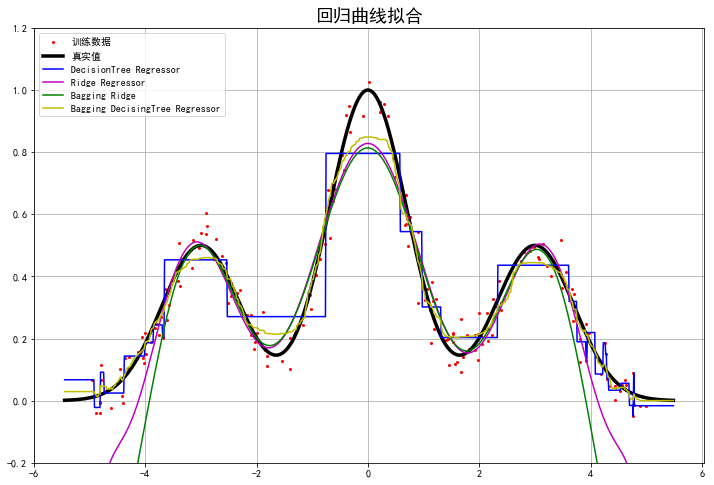

In [16]:
import matplotlib as mpl
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def f(x):
    return 0.5*np.exp(-(x+3)**2) + np.exp(-x**2) + 0.5*np.exp(-(x-3)**2)

np.random.seed(0)
N = 200
x = np.random.rand(N) * 10 -5
x = np.sort(x)
y = f(x) + 0.05*np.random.randn(N)
x.shape = -1,1

ridge = RidgeCV(alphas=np.logspace(-3,2,10),fit_intercept=False)
ridged = Pipeline([('poly',PolynomialFeatures(degree=10)),('Ridge',ridge)])
bagging_ridged = BaggingRegressor(ridged,n_estimators=100,max_samples=0.3)

dtr = DecisionTreeRegressor(max_depth=5)
regs = [('DecisionTree Regressor',dtr),('Ridge Regressor',ridged),('Bagging Ridge',bagging_ridged),
       ('Bagging DecisingTree Regressor',BaggingRegressor(dtr,n_estimators=100,max_samples=0.3))]

x_test = np.linspace(1.1*x.min(),1.1*x.max(),1000).reshape(-1,1)
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.plot(x,y,'ro',ms=2,label='训练数据')
plt.plot(x_test,f(x_test),'k-',lw=3.5,label='真实值')

clrs = 'bmgy'
for i,(name,reg) in enumerate(regs):
    reg.fit(x,y)
    y_hat = reg.predict(x_test)
    plt.plot(x_test,y_hat,color=clrs[i],label=name)
    print(reg.score(x,y))
plt.legend(loc='upper left')
plt.title('回归曲线拟合',fontsize=18)
plt.ylim(-0.2,1.2)
plt.grid()
plt.show()